# Feature Engineering

In [16]:
from os import path
import pandas as pd

datasetpath = path.join('..', 'dataset','races_cleaned.csv')
races = pd.read_csv(datasetpath)
races.head()

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,france-1978,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,spain-1991,0.0


### Feature 1: Classification of the races using a scoring system

First, we do a min-max normalization of the data necessary to calculate the scoring system. 

$$ x_{\text{norm}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} $$


In [17]:
races['profile_norm'] = (races['profile'] - races['profile'].min()) / (races['profile'].max() - races['profile'].min())
races['climb_total_norm'] = (races['climb_total'] - races['climb_total'].min()) / (races['climb_total'].max() - races['climb_total'].min())
races['length_norm'] = (races['length'] - races['length'].min()) / (races['length'].max() - races['length'].min())

After that, we calculate the score for the difficulty and classify each race by the score as follows:
$$ difficulty\_score = profile\_norm + climb\_total\_norm + length\_norm $$

In [18]:
races['difficulty_score'] = races['profile_norm'] + races['climb_total_norm'] + races['length_norm']

def classify_difficulty(score):
    if score <= 1:
        return "easy"
    elif 1 < score <= 2:
        return "moderate"
    elif 2 < score <= 3:
        return "hard"
    else:
        return "extreme"

races['difficulty_level'] = races['difficulty_score'].apply(classify_difficulty)

races.drop(columns=['profile_norm', 'climb_total_norm', 'length_norm'], inplace=True)
races.head()


,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,difficulty_score,difficulty_level
0,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,22.0,True,vini-ricordi-pinarello-sidermec-1986,0.0,0.635375,easy
1,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,norway-1987,0.0,0.635375,easy
2,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,france-1978,0.0,0.635375,easy
3,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,navigare-blue-storm-1993,0.0,0.635375,easy
4,tour-de-france/1978/stage-6,Tour de France,100.0,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,spain-1991,0.0,0.635375,easy


### Feature 2: Interation between the weight and the performance

(To be improved) This new feature combines `weight` and `position` to calculate a performance index for each race in the dataset.
$$ performance\_index = (1- norm\_weight) * (1 - norm\_position) $$

In [19]:


datasetpath = path.join('..', 'dataset','cyclists_cleaned.csv')
cyclists = pd.read_csv(datasetpath)
merged_df = races.merge(cyclists[['weight', '_url']], left_on='cyclist', right_on='_url', how='left')

merged_df['weight_norm'] = (merged_df['weight'] - merged_df['weight'].min()) / (merged_df['weight'].max() - merged_df['weight'].min())
merged_df['position_norm'] = (merged_df['position'] - merged_df['position'].min()) / (merged_df['position'].max() - merged_df['position'].min())

merged_df['performance_index'] = (1 - merged_df['position_norm']) * (1 - merged_df['weight_norm'])

correlation = merged_df[['performance_index', 'weight_norm', 'position_norm']].corr()

print("Correlation between performance index, weight, and position:")
print(correlation)

merged_df[['position', 'weight', 'weight_norm', 'position_norm', 'performance_index']].head()
races['performance_index'] = merged_df['performance_index']


Correlation between performance index, weight, and position:
                   performance_index  weight_norm  position_norm
performance_index           1.000000    -0.713476      -0.727131
weight_norm                -0.713476     1.000000       0.098442
position_norm              -0.727131     0.098442       1.000000


### Feature 3: See the most advantageous races

Now we calculate for each row the ratio between the points and the difficulty score. This ratio will be used to see which are the most advantageous races for the riders over the years.

$$ gain\_ratio = \frac{points}{difficulty\_score} $$

In [20]:
races['gain_ratio'] = (races['points']/races['difficulty_score'])
races[['points','difficulty_score', 'difficulty_level', 'gain_ratio']].drop_duplicates().head()

,points,difficulty_score,difficulty_level,gain_ratio
0,100.0,0.635375,easy,157.387288
106,80.0,2.377975,hard,33.642066
271,100.0,0.488587,easy,204.671737
426,50.0,0.855043,easy,58.476618
545,100.0,1.606011,moderate,62.266071


In [21]:
races.to_csv(path.join('..','dataset', 'races_final_enhanced.csv'), index=False)

## Data understanding for the new deatures

First of all, we analyze the distribution of the new features in the dataset.

In [32]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
seaborn.set_theme(style="whitegrid") 
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   _url               589865 non-null  object 
 1   name               589865 non-null  object 
 2   points             589865 non-null  float64
 3   length             589865 non-null  float64
 4   climb_total        589865 non-null  float64
 5   profile            589865 non-null  float64
 6   startlist_quality  589865 non-null  int64  
 7   date               589865 non-null  object 
 8   position           589865 non-null  int64  
 9   cyclist            589865 non-null  object 
 10  cyclist_age        589865 non-null  float64
 11  is_tarmac          589865 non-null  bool   
 12  cyclist_team       589865 non-null  object 
 13  delta              589865 non-null  float64
 14  difficulty_score   589865 non-null  float64
 15  difficulty_level   589865 non-null  object 
 16  pe

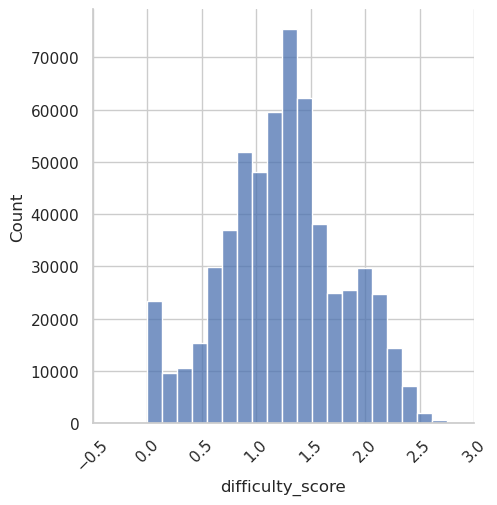

In [34]:
n = len(races)
num_bins = int(1 + np.log2(n))

g = seaborn.displot(races, x="difficulty_score", kind="hist", bins=num_bins)
g.set_xticklabels(rotation=45)
plt.show()


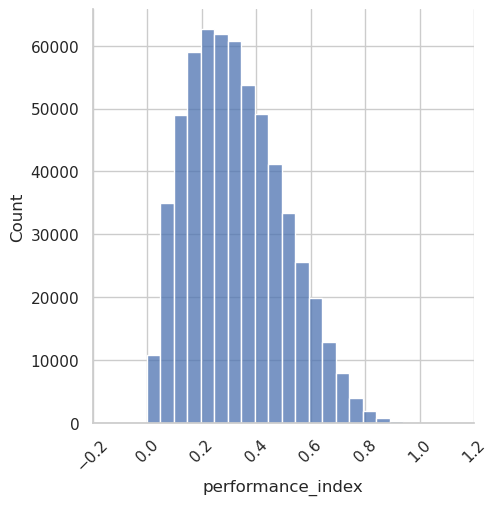

In [35]:
n = len(races)
num_bins = int(1 + np.log2(n))

g = seaborn.displot(races, x="performance_index", kind="hist", bins=num_bins)
g.set_xticklabels(rotation=45)
plt.show()


The data in `gain_ratio` is highly skewed, with the majority of values near zero and a few outliers at much higher values. This leads to an unbalanced histogram where most of the bins end up in the first interval. For this reason, we will use a logarithmic scale to better visualize the data.

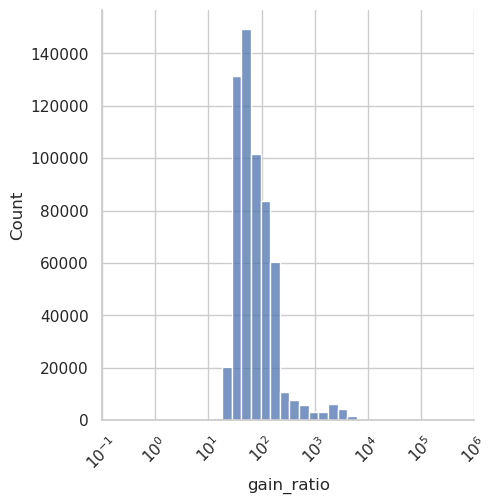

In [ ]:
g = seaborn.displot(races, x="gain_ratio", kind="hist", bins=num_bins, log_scale=(True, False))
g.set_xticklabels(rotation=45)
plt.show()

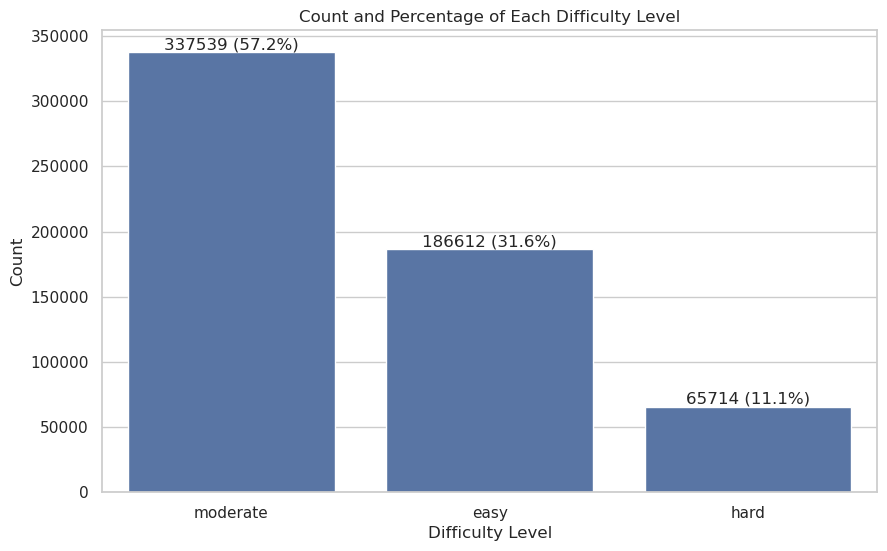

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate counts and percentages
difficulty_counts = races['difficulty_level'].value_counts()
difficulty_percentages = 100 * difficulty_counts / difficulty_counts.sum()

difficulty_data = (
    pd.DataFrame({'Count': difficulty_counts, 'Percentage': difficulty_percentages})
    .reset_index()
    .rename(columns={'index': 'difficulty_level'})
)

plt.figure(figsize=(10, 6))
sns.barplot(x='difficulty_level', y='Count', data=difficulty_data)  # Light blue color

# Annotate each bar with count and percentage
for index, row in difficulty_data.iterrows():
    plt.text(index, row['Count'], f"{row['Count']} ({row['Percentage']:.1f}%)", 
             ha='center', va='bottom')

plt.xlabel("Difficulty Level")
plt.ylabel("Count")
plt.title("Count and Percentage of Each Difficulty Level")
plt.show()


As you can see, most of the races (57.2%) in the dataset have a moderate difficulty according to our scoring system.

This difficulty level is followed by the easy (31.6%) and hard (11.1%) levels.